In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline


random_state = 42
np.random.seed(random_state)


In [2]:
data = pd.read_pickle("data_forecast_relative.pickle")

data.head()

,index,DATETIME,SYMBOL,PERMNO,INDUSTRY,VALUE,MOMENTUM,MONETARYPOLICY,GROWTH,INFLATION,RET,RET3,EXCESSRET,EXCESSRET3,LR,XGB,RF,LASSO,RIDGE,MLP
0,327,1963-02-28,ACF,10006,25,1.443624,0.096012,0.99,99.788054,0.012821,0.038700,0.116680,0.067552,0.057131,-109862.571464,-0.025957,0.042733,-0.379141,-0.386505,-1.332152
1,735,1963-03-31,ACF,10006,25,1.443624,0.133934,0.92,99.939763,0.009615,-0.009009,0.173573,-0.044473,0.066778,-109862.571825,-0.033951,0.042733,-0.379500,-0.386865,-1.336662
2,1151,1963-04-30,ACF,10006,25,1.443624,0.268752,1.00,100.074720,0.012821,0.084848,0.182715,0.036328,0.137539,-109862.571654,-0.042446,0.015307,-0.379320,-0.386695,-1.337328
3,1555,1963-05-31,ACF,10006,25,1.443624,0.189535,1.04,100.184328,0.012780,0.091620,0.040978,0.077293,0.051890,-109862.572586,-0.040053,0.028313,-0.380227,-0.387620,-1.338050
4,1947,1963-06-30,ACF,10006,25,1.443624,0.536269,1.07,100.262197,0.012780,-0.001289,0.069072,0.018909,0.047046,-109862.570940,-0.033218,-0.004567,-0.378610,-0.385987,-1.339516


In [3]:
# get unique dates
# function to take a dataframe, date, column
#   bucketitempdfe deciles, and set decile, return dataframe
# loop through dates, call function, accumulate dfs in list, concat

# for each bucket
#   select that bucket
#   group by date and average performance
#   save performance as a series
# graph 10 series

uniquedates = sorted(data["DATETIME"].unique())
uniquedates

[numpy.datetime64('1963-02-28T00:00:00.000000000'),
 numpy.datetime64('1963-03-31T00:00:00.000000000'),
 numpy.datetime64('1963-04-30T00:00:00.000000000'),
 numpy.datetime64('1963-05-31T00:00:00.000000000'),
 numpy.datetime64('1963-06-30T00:00:00.000000000'),
 numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1963-08-31T00:00:00.000000000'),
 numpy.datetime64('1963-09-30T00:00:00.000000000'),
 numpy.datetime64('1963-10-31T00:00:00.000000000'),
 numpy.datetime64('1963-11-30T00:00:00.000000000'),
 numpy.datetime64('1963-12-31T00:00:00.000000000'),
 numpy.datetime64('1964-01-31T00:00:00.000000000'),
 numpy.datetime64('1964-02-29T00:00:00.000000000'),
 numpy.datetime64('1964-03-31T00:00:00.000000000'),
 numpy.datetime64('1964-04-30T00:00:00.000000000'),
 numpy.datetime64('1964-05-31T00:00:00.000000000'),
 numpy.datetime64('1964-06-30T00:00:00.000000000'),
 numpy.datetime64('1964-07-31T00:00:00.000000000'),
 numpy.datetime64('1964-08-31T00:00:00.000000000'),
 numpy.datet

In [4]:
num_buckets = 5

def bucket_df_by_col(df, col):
    # compute decile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    vals = pd.qcut(df[col], num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df


In [5]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "MOMENTUM") for d in uniquedates]
datanew= pd.concat(dflist)
datanew

/home/ubuntu/anaconda2/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,DATETIME,SYMBOL,PERMNO,INDUSTRY,VALUE,MOMENTUM,MONETARYPOLICY,GROWTH,INFLATION,...,RET3,EXCESSRET,EXCESSRET3,LR,XGB,RF,LASSO,RIDGE,MLP,MOMENTUM_RANK
0,327,1963-02-28,ACF,10006,25,1.443624,0.096012,0.99,99.788054,0.012821,...,0.116680,0.067552,0.057131,-109862.571464,-0.025957,0.042733,-0.379141,-0.386505,-1.332152,4
629,202,1963-02-28,AN,10102,14,0.795584,-0.134733,0.99,99.788054,0.012821,...,0.020185,0.024427,-0.036089,-574486.886523,-0.037059,-0.073511,-0.385728,-0.393349,-1.373324,1
1907,132,1963-02-28,AYE,10137,31,0.519467,0.048083,0.99,99.788054,0.012821,...,-0.000325,0.023986,-0.055582,-953388.699668,-0.033912,-0.053544,-0.388990,-0.396619,-1.378696,3
2838,38,1963-02-28,HON,10145,41,0.649213,-0.131779,0.99,99.788054,0.012821,...,0.116143,-0.005308,0.061802,-547383.995251,-0.038894,-0.105439,-0.387167,-0.394818,-1.397988,1
3782,291,1963-02-28,AH,10153,21,2.372537,-0.276882,0.99,99.788054,0.012821,...,0.066844,0.006793,0.012698,-596900.726122,-0.011751,-0.055312,-0.374512,-0.381665,-1.359700,0
3963,124,1963-02-28,AMX,10161,28,0.579169,-0.133410,0.99,99.788054,0.012821,...,0.100502,0.042472,0.042937,-352149.397245,-0.037437,-0.073626,-0.386866,-0.394389,-1.346978,1
4660,70,1963-02-28,BEAM,10225,17,0.625877,-0.373389,0.99,99.788054,0.012821,...,0.058830,-0.040536,0.007183,-458136.127001,-0.017194,-0.059617,-0.388531,-0.396234,-1.362446,0
5273,279,1963-02-28,ABC,10233,32,0.900164,-0.174683,0.99,99.788054,0.012821,...,-0.117215,-0.091838,-0.163654,-553600.475635,-0.028749,-0.069162,-0.384771,-0.392189,-1.360923,1
5547,72,1963-02-28,PA,10241,39,0.756432,0.041024,0.99,99.788054,0.012821,...,-0.037433,0.007462,-0.091030,-272840.692195,-0.029414,-0.053248,-0.384948,-0.392626,-1.356920,3
6510,167,1963-02-28,AMO,10321,23,0.925821,0.123104,0.99,99.788054,0.012821,...,-0.008941,0.045001,-0.065294,-477566.458237,-0.026556,-0.051970,-0.384315,-0.391912,-1.367361,4


,Label,Annualized return,Annualized volatility
0,Quintile 0,7.125042,0.214952
1,Quintile 1,10.695724,0.164168
2,Quintile 2,11.394011,0.151217
3,Quintile 3,12.609458,0.156358
4,Quintile 4,17.139954,0.200060


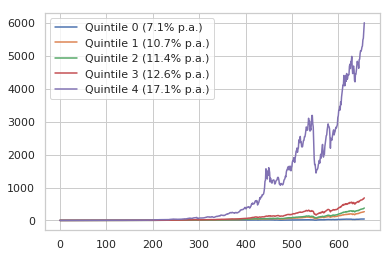

In [6]:
# performance by bucket
def perf_by_bucket(df, col, rank):
    perf = df.loc[df[col]==rank][["DATETIME", col, "RET"]]\
        .groupby("DATETIME")\
        .mean()\
        .reset_index()
    return perf

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "MOMENTUM_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.plot(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)

/home/ubuntu/anaconda2/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,9.711780,0.195339
1,Quintile 1,10.862307,0.174491
2,Quintile 2,11.956204,0.161044
3,Quintile 3,13.023519,0.160703
4,Quintile 4,14.094920,0.163525


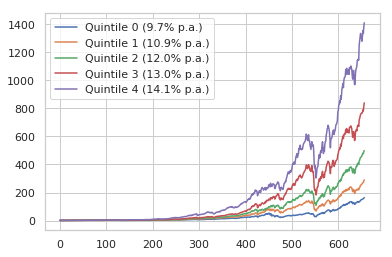

In [7]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "XGB") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "XGB_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.plot(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)


/home/ubuntu/anaconda2/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,11.278745,0.180701
1,Quintile 1,11.530725,0.165427
2,Quintile 2,11.513340,0.159478
3,Quintile 3,11.726716,0.159856
4,Quintile 4,13.763516,0.173329


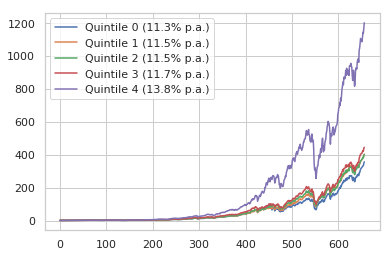

In [8]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "RF") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "RF_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.plot(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)


/home/ubuntu/anaconda2/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,12.398472,0.168709
1,Quintile 1,11.625235,0.184274
2,Quintile 2,11.765961,0.151753
3,Quintile 3,12.057569,0.178387
4,Quintile 4,11.523659,0.177394


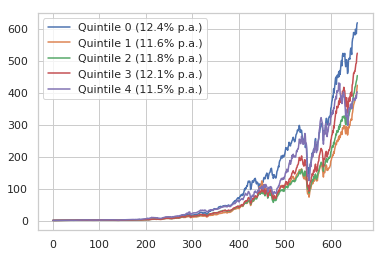

In [9]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "MLP") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "MLP_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.plot(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)


/home/ubuntu/anaconda2/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Label,Annualized return,Annualized volatility
0,Quintile 0,6.070330,0.195600
1,Quintile 1,10.160257,0.164569
2,Quintile 2,12.359313,0.155866
3,Quintile 3,14.103779,0.159167
4,Quintile 4,16.944891,0.185273


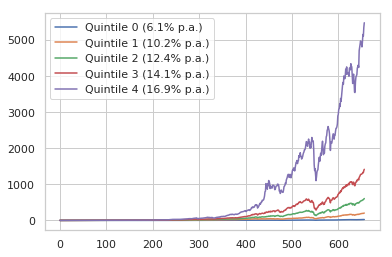

In [10]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "LASSO") for d in uniquedates]
datanew= pd.concat(dflist)

reportdict = {'Label': [],
             'Annualized return' : [],
             'Annualized volatility' : []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "LASSO_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.plot(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)


In [11]:
0.156358/0.200060 * 17.139954

13.395825889893032

In [12]:
IBM = datanew.loc[datanew['SYMBOL']=="IBM"]
IBM[["DATETIME", "RET", "MOMENTUM"]].tail(100)

,DATETIME,RET,MOMENTUM
37807,2009-07-31,0.129381,-0.084515
37808,2009-08-31,0.005681,-0.166953
37809,2009-09-30,0.013215,-0.014913
37810,2009-10-31,0.008361,0.031087
37811,2009-11-30,0.052152,0.314290
37812,2009-12-31,0.036011,0.500744
37813,2010-01-31,-0.065011,0.530980
37814,2010-02-28,0.043468,0.456488
37815,2010-03-31,0.008572,0.348849
37816,2010-04-30,0.005848,0.336881


In [13]:
LATEST = datanew.loc[datanew['DATETIME']=="2017-12-31"]
LATEST.tail(36)[["DATETIME", "SYMBOL", "MOMENTUM", "MOMENTUM_RANK"]]

KeyError: "['MOMENTUM_RANK'] not in index"

In [ ]:
datanew.groupby(["DATETIME","MOMENTUM_RANK"]).mean()

In [ ]:
tempdf = perf_by_bucket(datanew, "MOMENTUM_RANK", 4)
tempdf["RET1P"] = 1 + tempdf["RET"]
tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
tempdf

In [ ]:
tempdf["RET"].std() * np.sqrt(12)

In [ ]:
3467.590636**(1/55)
1.09*55

In [ ]:
datanew.loc[datanew["MOMENTUM_RANK"]==0][["DATETIME", "MOMENTUM_RANK", "RET"]]\
        .groupby(["DATETIME"])\
        .count()\
        .reset_index().to_csv("x.csv")


In [ ]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d], "OLSALL") for d in uniquedates]
datanew= pd.concat(dflist)
datanew

In [ ]:
reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : []
             }

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, "OLSALL_RANK", i)
    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["RET"].std() * np.sqrt(12)

    plt.plot(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    
plt.legend();

pd.DataFrame(reportdict)